,arch,hyperparams,train loss,valid loss,accuracy,time
0,LSTM,"{'n_layers': 3, 'bidirectional': False}",0.693249,0.693474,0.500000,17
1,LSTM,"{'n_layers': 2, 'bidirectional': True}",0.693272,0.694611,0.500000,25
2,LSTM,"{'n_layers': 3, 'bidirectional': True}",0.693358,0.694245,0.483333,40
3,LSTM,"{'n_layers': 2, 'bidirectional': False}",0.692956,0.694807,0.450000,11
4,LSTM,"{'n_layers': 1, 'bidirectional': False}",0.693021,0.695547,0.433333,5
5,LSTM,"{'n_layers': 1, 'bidirectional': True}",0.693092,0.695710,0.433333,11
6,XceptionTime,{},0.676579,0.820711,0.433333,43
7,InceptionTime,{},0.695144,0.765289,0.366667,38
8,OmniScaleCNN,{},0.695052,0.735818,0.366667,102
9,mWDN,{'levels': 4},0.686099,0.716700,0.366667,38


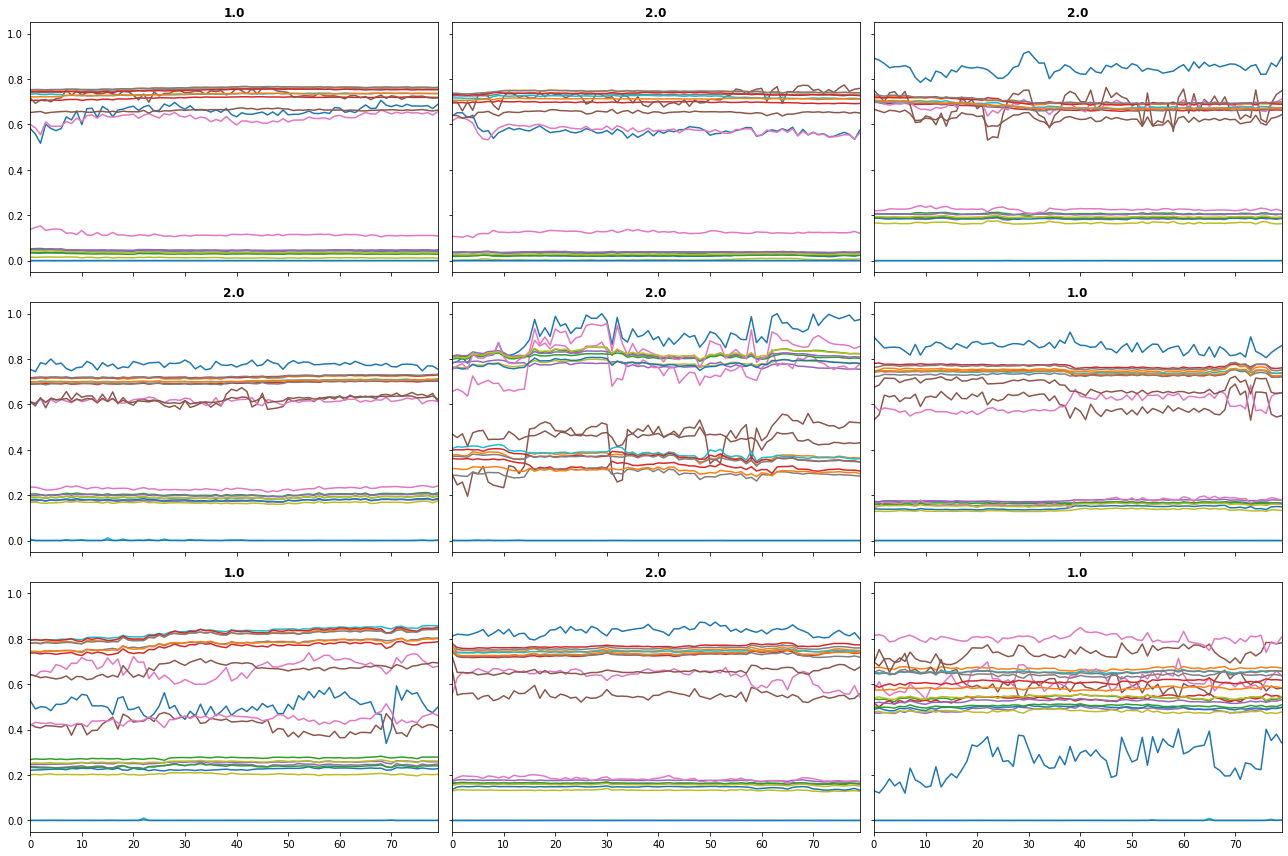

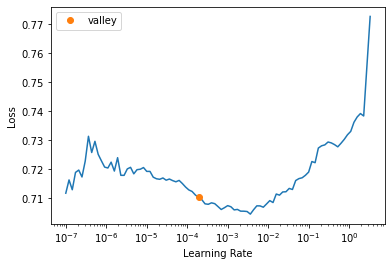

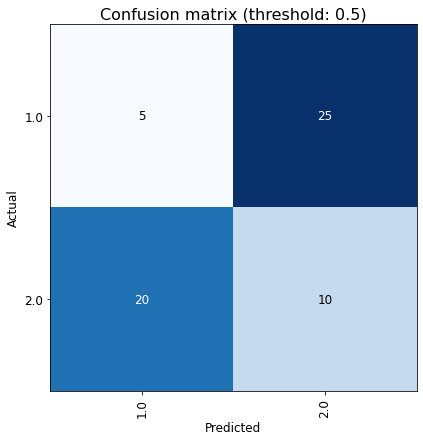

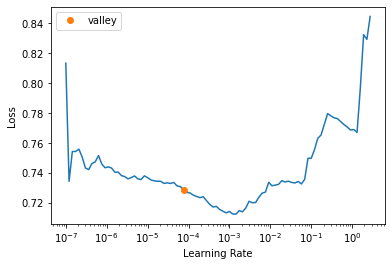

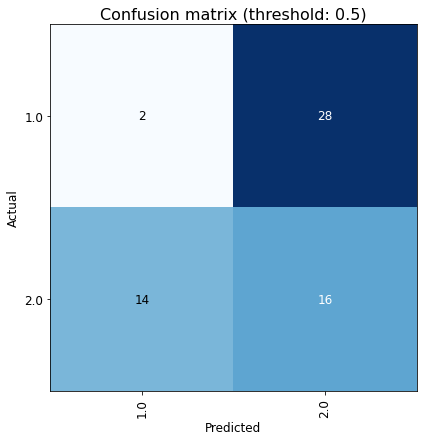

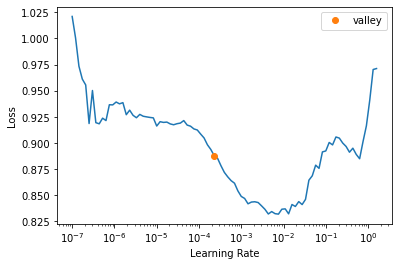

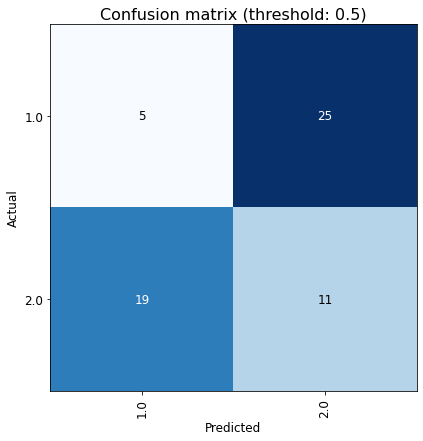

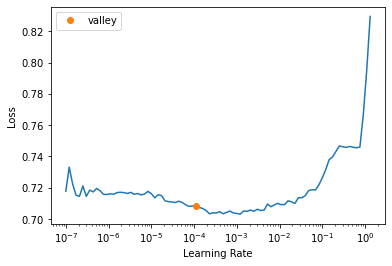

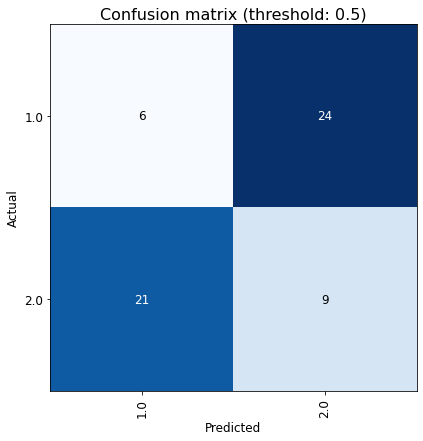

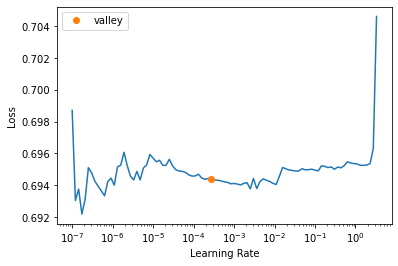

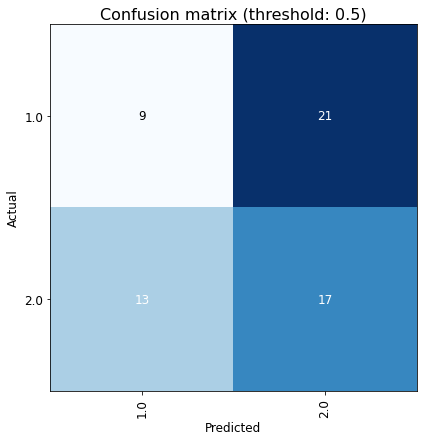

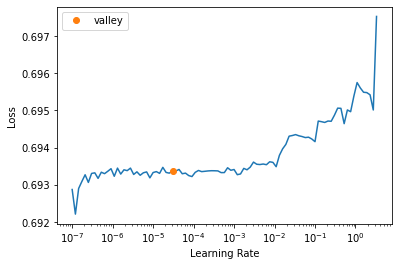

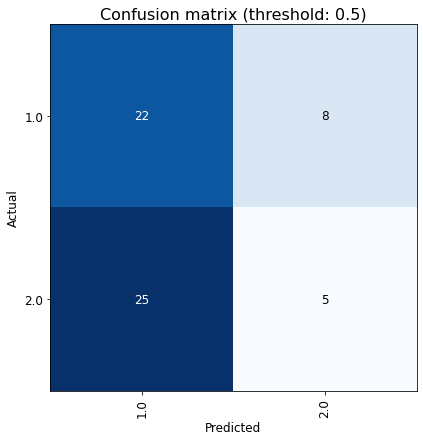

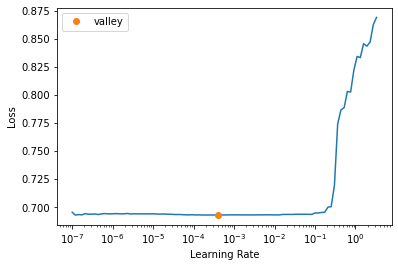

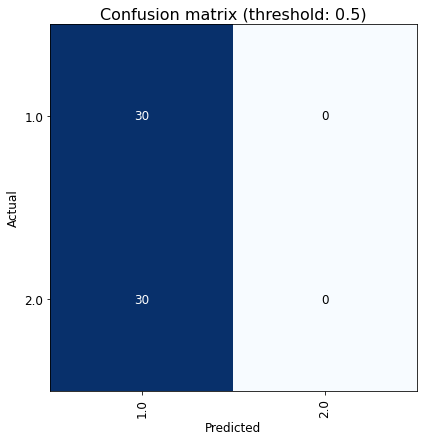

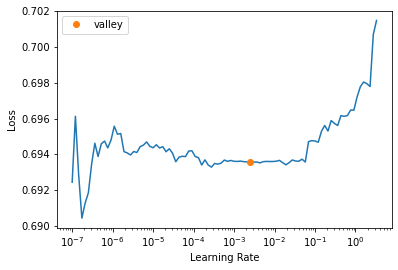

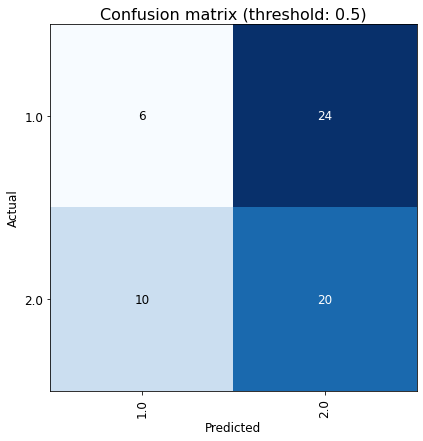

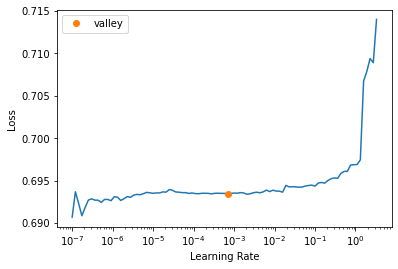

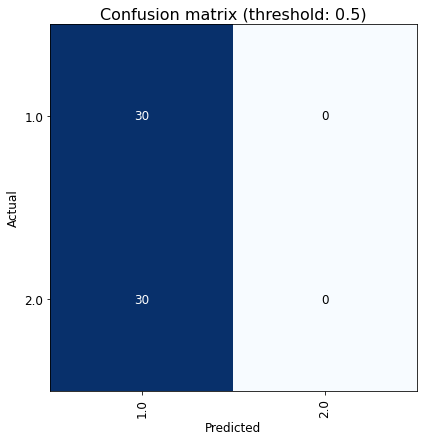

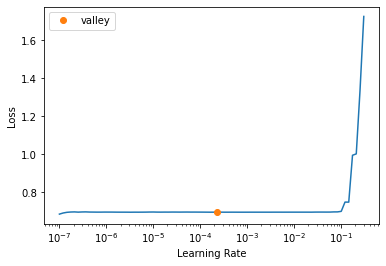

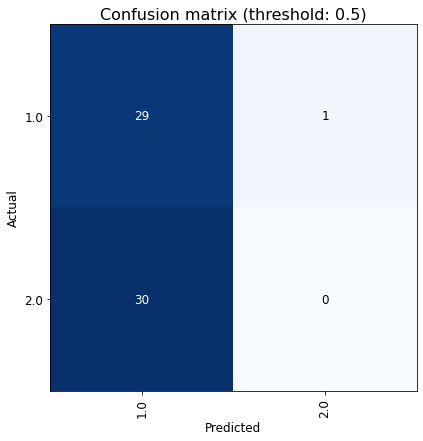

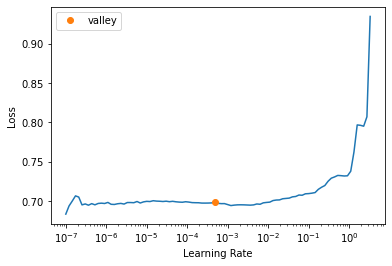

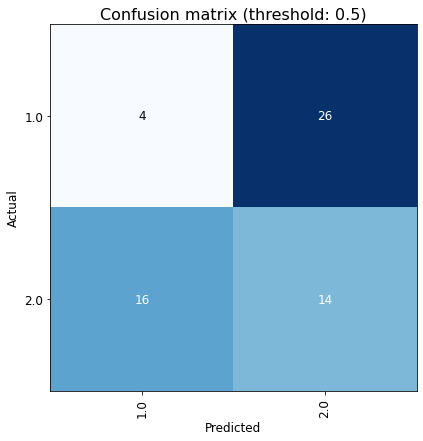

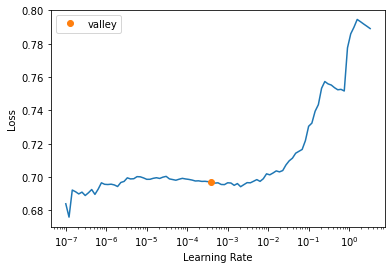

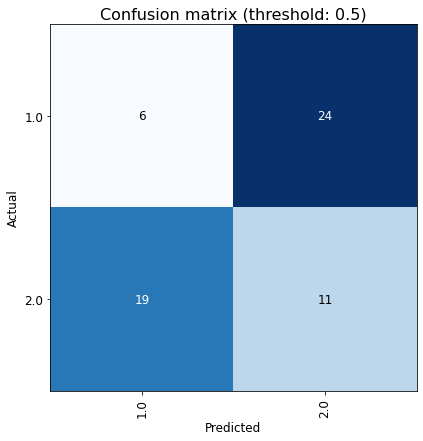

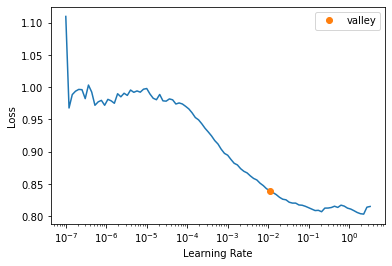

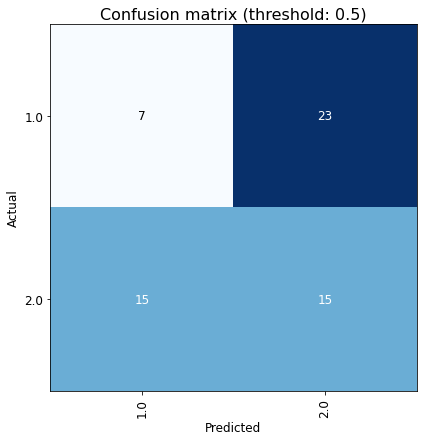

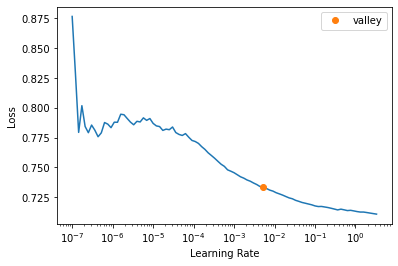

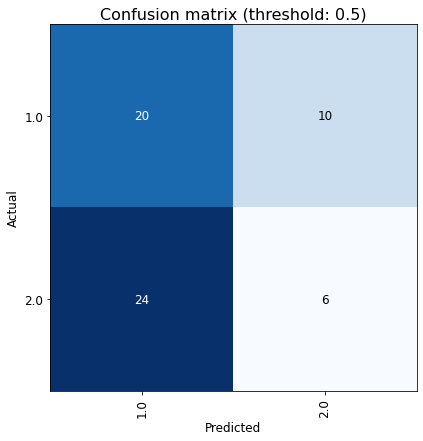

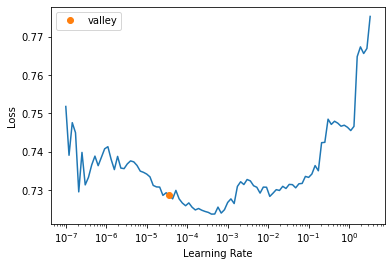

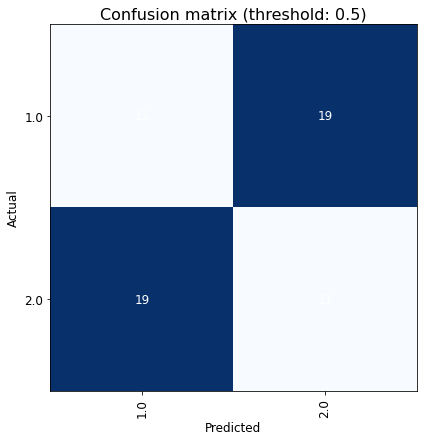

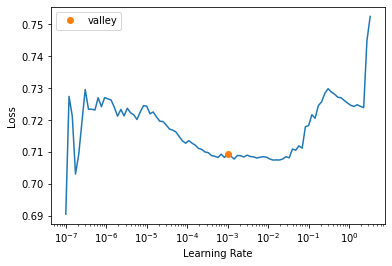

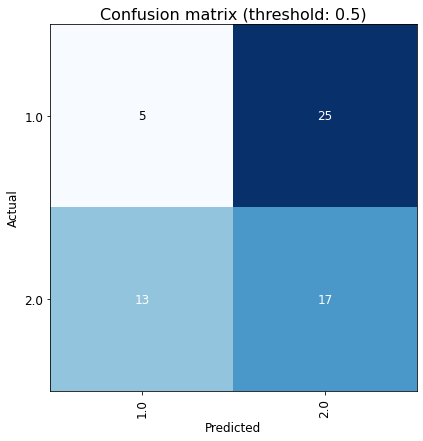

In [7]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
from IPython.display import clear_output
import datetime


num_scenario = 3
nr_taps = 2
learning_cycles = 25
features_to_learn_with = ["pitch","nosetip_y","nosetip_x","chin_x","chin_y","roll","yaw","left_eye_corner_x","left_eye_corner_y","right_eye_corner_x","right_eye_corner_y","left_mouth_corner_x","left_mouth_corner_y","right_mouth_corner_x","right_mouth_corner_y","nose_end_point_x","nose_end_point_y","head_pose1_x","head_pose1_y","head_pose2_x","head_pose2_y"]
feature_list_string = '_'.join(features_to_learn_with)
models_folder = "models"
plots_folder = "vis/plots"

dl = dataloader(scenario= num_scenario, path="/Users/adi/Nextcloud/smart_hans/AP2/Daten/headpose_opencv_pitch_roll_yaw_20220904", nr_taps=nr_taps, move_window_by=-10, feature_list=features_to_learn_with)
df_n = dl.df

cols = list(df_n.columns)
a, b = cols.index('sample_index'), cols.index('feature')
cols[b], cols[a] = cols[a], cols[b]
df_n = df_n[cols]
print(df_n)
df_n = df_n.sort_values(['feature','target'])#.reset_index(drop=True)

print(df_n["feature"])
print(df_n['sample_index'])
print(" hhhhhhhh ")

X, old_y, names = df2xy (df_n, sample_col='sample_index', feat_col='feature', target_col='target', data_cols=None, steps_in_rows=True, return_names=True)

print(names)
print(f"shape ours {df_n.shape}")

print("our X")
print(X.shape)
print(X)

print("our y")
print(old_y)
print(old_y.shape)

y = np.empty(len(old_y))
for i, elem in enumerate(old_y):
            remainder = int(elem[0]) % 10
            y[i] = remainder
print(y)
print(y.shape)
   
splits = get_splits(y, valid_size=.2)

tfms  = [None, TSRegression()]

dsets = TSDatasets( X,y,  inplace=True, splits=splits, tfms=[None, TSClassification()])

print(dsets)

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, num_workers=0, tfms=[None, TSClassification()], item_tfs=TSClassification())

dls.show_batch(sharey=True)

archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
        (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
        (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
        (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

results = pd.DataFrame(columns=['arch', 'hyperparams',  'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):

    save_name = "multivariate_scenario_{}_{}_features_{}".format(num_scenario, arch.__name__,"features: "+str(len(features_to_learn_with)))
    ## set parameters for modelsaves
    scenario_name_stage0 = save_name+"_nr_taps_{}".format(str(nr_taps))+"_stage0"

    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)

    learn.save(scenario_name_stage0)
    learn.load(scenario_name_stage0)
    learn.lr_find()
    scenario_name_stage1 = scenario_name_stage0.replace("0","1")

    start = time.time()
    learn.fit_one_cycle(learning_cycles, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    
    learn.plot_confusion_matrix()
    current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
    plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_features_{}_learning_cycles_{}_{}.png".format(str(nr_taps),str(len(features_to_learn_with)),learning_cycles, current_time)
    plt.savefig(plot_name, ext='png', bbox_inches="tight")
    clear_output(wait=True)
    display(results)
